In [1]:
%matplotlib inline

Train FCN on Pascal VOC Dataset
=====================================

This is a semantic segmentation tutorial using Gluon CV toolkit, a step-by-step example.
The readers should have basic knowledge of deep learning and should be familiar with Gluon API.
New users may first go through `A 60-minute Gluon Crash Course <http://gluon-crash-course.mxnet.io/>`_.
You can `Start Training Now`_ or `Dive into Deep`_.

Start Training Now
~~~~~~~~~~~~~~~~~~

.. hint::

    Feel free to skip the tutorial because the training script is self-complete and ready to launch.

    :download:`Download Full Python Script: train.py<../../../scripts/segmentation/train.py>`

    Example training command::

        # First training on augmented set
        CUDA_VISIBLE_DEVICES=0,1,2,3 python train.py --dataset pascal_aug --model fcn --backbone resnet50 --lr 0.001 --checkname mycheckpoint
        # Finetuning on original set
        CUDA_VISIBLE_DEVICES=0,1,2,3 python train.py --dataset pascal_voc --model fcn --backbone resnet50 --lr 0.0001 --checkname mycheckpoint --resume runs/pascal_aug/fcn/mycheckpoint/checkpoint.params

    For more training command options, please run ``python train.py -h``
    Please checkout the `model_zoo <../model_zoo/index.html#semantic-segmentation>`_ for training commands of reproducing the pretrained model.

Dive into Deep
~~~~~~~~~~~~~~



In [6]:
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd
import gluoncv

Fully Convolutional Network
---------------------------

![](https://cdn-images-1.medium.com/max/800/1*wRkj6lsQ5ckExB5BoYkrZg.png)

    :width: 70%
    :align: center

(figure credit to `Long et al. <https://arxiv.org/pdf/1411.4038.pdf>`_ )

State-of-the-art approaches of semantic segmentation are typically based on
Fully Convolutional Network (FCN) [Long15]_.
The key idea of a fully convolutional network is that it is "fully convolutional",
which means it does have any fully connected layers. Therefore, the network can
accept arbitrary input size and make dense per-pixel predictions.
Base/Encoder network is typically pre-trained on ImageNet, because the features
learned from diverse set of images contain rich contextual information, which
can be beneficial for semantic segmentation.





Model Dilation
--------------

The adaption of base network pre-trained on ImageNet leads to loss spatial resolution,
because these networks are originally designed for classification task.
Following standard implementation in recent works of semantic segmentation,
we apply dilation strategy to the
stage 3 and stage 4 of the pre-trained networks, which produces stride of 8
featuremaps (models are provided in
:class:`gluoncv.model_zoo.ResNetV1b`).
Visualization of dilated/atrous convoution
(figure credit to `conv_arithmetic <https://github.com/vdumoulin/conv_arithmetic>`_ ):

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/dilation.gif)

    :width: 40%
    :align: center

Loading a dilated ResNet50 is simply:




In [7]:
pretrained_net = gluoncv.model_zoo.resnet50_v1b(pretrained=True)

Model file is not found. Downloading.


100%|██████████| 55344/55344 [00:01<00:00, 34707.14KB/s]


For convenience, we provide a base model for semantic segmentation, which automatically
load the pre-trained dilated ResNet :class:`gluoncv.model_zoo.segbase.SegBaseModel`
with a convenient method ``base_forward(input)`` to get stage 3 & 4 featuremaps:




In [8]:
basemodel = gluoncv.model_zoo.segbase.SegBaseModel(nclass=10, aux=False)
x = mx.nd.random.uniform(shape=(1, 3, 224, 224))
c3, c4 = basemodel.base_forward(x)
print('Shapes of c3 & c4 featuremaps are ', c3.shape, c4.shape)

Model file is not found. Downloading.


57418KB [00:01, 33850.65KB/s]                           


Shapes of c3 & c4 featuremaps are  (1, 1024, 28, 28) (1, 2048, 28, 28)


FCN Model
---------

We build a fully convolutional "head" on top of the base network,
the FCNHead is defined as::

    class _FCNHead(HybridBlock):
        def __init__(self, in_channels, channels, norm_layer, **kwargs):
            super(_FCNHead, self).__init__()
            with self.name_scope():
                self.block = nn.HybridSequential()
                inter_channels = in_channels // 4
                with self.block.name_scope():
                    self.block.add(nn.Conv2D(in_channels=in_channels, channels=inter_channels,
                                             kernel_size=3, padding=1))
                    self.block.add(norm_layer(in_channels=inter_channels))
                    self.block.add(nn.Activation('relu'))
                    self.block.add(nn.Dropout(0.1))
                    self.block.add(nn.Conv2D(in_channels=inter_channels, channels=channels,
                                             kernel_size=1))

    def hybrid_forward(self, F, x):
        return self.block(x)

FCN model is provided in :class:`gluoncv.model_zoo.FCN`. To get
FCN model using ResNet50 base network for Pascal VOC dataset:



In [9]:
model = gluoncv.model_zoo.get_fcn(dataset='pascal_voc', backbone='resnet50', pretrained=False)
print(model)

FCN(
  (conv1): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (5): Activation(relu)
    (6): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
  (relu): Activation(relu)
  (maxpool): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (layer1): HybridSequential(
    (0): BottleneckV1b(
      (conv1): Conv2D(128 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=Fals

Dataset and Data Augmentation
-----------------------------

image transform for color normalization



In [10]:
from mxnet.gluon.data.vision import transforms
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

We provide semantic segmentation datasets in :class:`gluoncv.data`.
For example, we can easily get the Pascal VOC 2012 dataset:



In [18]:
!python pascal_voc.py

100%|██████████████████████████████| 1952773/1952773 [02:11<00:00, 14838.28KB/s]
1386270KB [01:00, 22930.01KB/s]                                                 


In [19]:
trainset = gluoncv.data.VOCSegmentation(split='train', transform=input_transform)
print('Training images:', len(trainset))
# set batch_size = 2 for toy example
batch_size = 2
# Create Training Loader
train_data = gluon.data.DataLoader(
    trainset, batch_size, shuffle=True, last_batch='rollover',
    num_workers=batch_size)

Training images: 2913


For data augmentation,
we follow the standard data augmentation routine to transform the input image
and the ground truth label map synchronously. (*Note that "nearest"
mode upsample are applied to the label maps to avoid messing up the boundaries.*)
We first randomly scale the input image from 0.5 to 2.0 times, then rotate
the image from -10 to 10 degrees, and crop the image with padding if needed.
Finally a random Gaussian blurring is applied.

Random pick one example for visualization:



In [20]:
import random
from datetime import datetime
random.seed(datetime.now())
idx = random.randint(0, len(trainset))
img, mask = trainset[idx]
from gluoncv.utils.viz import get_color_pallete, DeNormalize
# get color pallete for visualize mask
mask = get_color_pallete(mask.asnumpy(), dataset='pascal_voc')
mask.save('mask.png')
# denormalize the image
img = DeNormalize([.485, .456, .406], [.229, .224, .225])(img)
img = np.transpose((img.asnumpy()*255).astype(np.uint8), (1, 2, 0))

Plot the image and mask



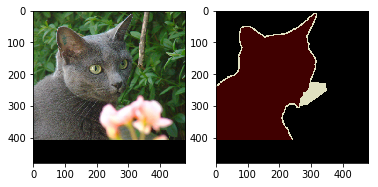

In [21]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)

plt.imshow(img)
# subplot 2 for the mask
mmask = mpimg.imread('mask.png')
fig.add_subplot(1,2,2)
plt.imshow(mmask)
# display
plt.show()

Training Details
----------------

- Training Losses:

    We apply a standard per-pixel Softmax Cross Entropy Loss to train FCN. For Pascal
    VOC dataset, we ignore the loss from boundary class (number 22).
    Additionally, an Auxiliary Loss as in PSPNet [Zhao17]_ at Stage 3 can be enabled when
    training with command ``--aux``. This will create an additional FCN "head" after Stage 3.




In [22]:
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
criterion = MixSoftmaxCrossEntropyLoss(aux=True)

- Learning Rate and Scheduling:

    We use different learning rate for FCN "head" and the base network. For the FCN "head",
    we use $10\times$ base learning rate, because those layers are learned from scratch.
    We use a poly-like learning rate scheduler for FCN training, provided in :class:`gluoncv.utils.LRScheduler`.
    The learning rate is given by $lr = baselr \times (1-iter)^{power}$




In [23]:
lr_scheduler = gluoncv.utils.LRScheduler(mode='poly', baselr=0.001, niters=len(train_data), 
                                          nepochs=50)

- Dataparallel for multi-gpu training, using cpu for demo only



In [24]:
from gluoncv.utils.parallel import *
ctx_list = [mx.gpu(0)]
model = DataParallelModel(model, ctx_list)
criterion = DataParallelCriterion(criterion, ctx_list)

- Create SGD solver



In [25]:
kv = mx.kv.create('device')
optimizer = gluon.Trainer(model.module.collect_params(), 'sgd',
                          {'lr_scheduler': lr_scheduler,
                           'wd':0.0001,
                           'momentum': 0.9,
                           'multi_precision': True},
                          kvstore = kv)

The training loop
-----------------




In [26]:
train_loss = 0.0
epoch = 0
for i, (data, target) in enumerate(train_data):
    lr_scheduler.update(i, epoch)
    with autograd.record(True):
        outputs = model(data)
        losses = criterion(outputs, target)
        mx.nd.waitall()
        autograd.backward(losses)
    optimizer.step(batch_size)
    for loss in losses:
        train_loss += loss.asnumpy()[0] / len(losses)
    print('Epoch %d, batch %d, training loss %.3f'%(epoch, i, train_loss/(i+1)))
    # just demo for 2 iters
    if i > 1:
        print('Terminated for this demo...')
        break

Epoch 0, batch 0, training loss 3.903
Epoch 0, batch 1, training loss 3.675
Epoch 0, batch 2, training loss 3.575
Terminated for this demo...


You can `Start Training Now`_.

References
----------

.. [Long15] Long, Jonathan, Evan Shelhamer, and Trevor Darrell. \
    "Fully convolutional networks for semantic segmentation." \
    Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

.. [Zhao17] Zhao, Hengshuang, Jianping Shi, Xiaojuan Qi, Xiaogang Wang, and Jiaya Jia. \
    "Pyramid scene parsing network." IEEE Conf. on Computer Vision and Pattern Recognition (CVPR). 2017.


